## Based on CRTS_sel_g_cut_vs_r_cut.ipynb,   taking only the code needed to make Fig. 3

A testbed for making Fig.3 :  the 4 x 4 histogram plot. It shows that   0   < log(tau) < 1.7 (short timescales bin), does not exhibit any variability, because chi_ij for qso and stars is almost undistinguishable for uncorrected points. 

The files in  SF_plotting/Histogram_r_cut_starsB_qso/    are described in README. 

To make them  one would run points 1-10  (numeration inherited from CRTS_sel_g_cut_vs_r_cut.ipynb )   for different mag cuts :  17-18 ,  18-18.5 ,  18.5-19 , thus producing  8 files per cut (4 for qso,  4 for Blue Stars ) . 

Thus saved in SF_plotting/Histogram_r_cut_starsB_qso/   , one would read them all in 10)a) , and plot the histogram. 

NOTE:  that these points have no correction , they have exactly the same e_ij as from master files . |

NOTE : if Fig_3_prereq-get_tau_samples_and_fc.ipynb  has been executed, then we already have all the log(tau) samples, and so JUMP STRAIGHT TO PART 10)a) : plotting 


In [21]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import CRTS_paper_modules as mod
import datetime
reload(mod)

<module 'CRTS_paper_modules' from 'CRTS_paper_modules.py'>

In [2]:
cols1, qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()


Zipping CRTS-SDSS quasars catalog from  ../data_products/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt  ...
Read in  7601 , quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for  48250 , stars from CRTS


## 1) Read in points  m_ij , e_ij , tau  from master files 

In [7]:
star_cat

{'CRTS_M': array([ 20.04798,  15.95652,  17.47582, ...,  19.74864,  17.12618,  20.002  ]),
 'CRTS_Merr': array([ 0.18944,  0.03524,  0.05099, ...,  0.13395,  0.04733,  0.2385 ]),
 'N_rows': array([  23.,   90.,   99., ...,  114.,   94.,   72.]),
 'crts_id': array([ 392106.,  315542.,  700105., ...,  964473.,  864141.,  744009.]),
 'dec_CRTS': array([-0.79702,  0.4    , -0.50307, ..., -1.20402, -1.18179, -0.42934]),
 'dec_SDSS': array([-0.79702,  0.4    , -0.50307, ..., -1.20402, -1.18179, -0.42934]),
 'g_Nobs': array([  4.,  13.,   9., ...,  10.,   9.,  11.]),
 'g_mMed': array([ 22.49 ,  16.886,  18.101, ...,  21.743,  17.757,  22.042]),
 'i_mMed': array([ 19.927,  15.848,  17.205, ...,  19.194,  17.07 ,  19.419]),
 'm_ang_deg': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'mjd_N': array([  23.,   90.,   99., ...,  114.,   94.,   72.]),
 'mjd_span': array([ 3041.,  2920.,  3070., ...,  2997.,  3055.,  3042.]),
 'r_mMed': array([ 21.068,  16.174,  17.473, ...,  20.351,  17.242,  20.634]

In [22]:
Min = 17
Max = 18
magnitudes = ['r']  # don't need g magnitude , decided to use only r magnitude 

# Where to save the samples of log(tau), as well as the table results  ... 

# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_3_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_3_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)

print('Today we will save our Fig_3 files in %s'%outDir)

objects_in_cut = {}

for mag in magnitudes : 
    cut_mag = mag
   
    
    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))


    good_ids_S_blue = mod.cut_stars(star_cat = star_cat, mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,  gi_Max=1, cut_mag=cut_mag + '_mMed')
    
    #good_ids_S_red = mod.cut_stars(star_cat = star_cat, mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, 
    #                                       gi_Max=3, cut_mag=cut_mag + '_mMed')
    
    good_ids_QSO = mod.cut_qso(qso_cat = qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                               cut_mag=cut_mag)
    objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'qso':good_ids_QSO}
    

Today we will save our Fig_3 files in /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_3_data/2016-06-07/

Using now only lightcurves with SDSS  17.000000< r < 18.000000

 These cuts reduced the number of stars  in the sample from 48250  to  2795
Returning only QSO which had an SDSS counterpart within 0.000278 radians

 These cuts reduced the number of qso  in the sample from 7601  to  185


## Since I'm only using r_cut,   I won't compare it with g_cut .  Thus making r_bin is the same as r_cut  

In [23]:
bins = {}
bin_types = ['r_cut']  # removed 'g_cut'

objects = objects_in_cut['r'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    bins['r_cut'][obj] =  objects_in_cut['r'][obj]


## Read the xi, ei for objects in the r_cut ... 

In [24]:
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso/'

out_dic = {}

#for b in bins.keys():
# read in only r_cut 

b = 'r_cut'
print 'Reading in xi, ei for bin ', b
out_dic[b] = {}   # initialize the dic 

good_ids_S_blue = bins[b]['starsB']
#good_ids_S_red = bins[b]['starsR']
good_ids_QSO = bins[b]['qso']

qso, starB = mod.read_xi_ei(inDirStars, good_ids_S_blue, inDirQSO, good_ids_QSO)

# put into a dictionary : makes it more explicit 
out_dic[b] = {'starsB': starB, 'qso':qso}


# Straight after reading-in xi, ei,   one can proceed directly to part 9) (one bin) or 10 : all bins sigma comparison 
# or to Saving just the log(tau) samples of xi, tau, ei. 


Reading in xi, ei for bin  r_cut
making new delflx, tau, xi arrays


----- Already read 100% of qso 

----- Already read 100% of Blue Stars 



## 10) Save to a file all points for samples of log(tau) for a given mag cut, only for qso and starsB 

In [25]:
## Save to a file points for log(tau) samples  for QSO, stars 

b = 'r_cut'   # or g_cut

tau_min_arr = [0,   2.3, 2.8, 3.2]
tau_max_arr = [1.7, 2.5, 3.0, 3.4]
for obj in ['qso','starsB']:
    #obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic[b][obj][0]
    tau =  out_dic[b][obj][1]
    e_ij =  out_dic[b][obj][2]
    
    for i in range(len(tau_min_arr)):
        m1 = tau_min_arr[i] < np.log10(tau)
        m2 = np.log10(tau) < tau_max_arr[i]
        mask =  m1 * m2 

        data = np.column_stack((m_ij[mask], tau[mask], e_ij[mask]))
       
        fname = b+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_mi_tau_ei-log_tau_'+\
                str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
        print 'Saved', fname
        np.savetxt(outDir+fname, data, fmt='%s', delimiter= ' ')


Saved r_cut_17-18_qso_mi_tau_ei-log_tau_0-1.7.txt
Saved r_cut_17-18_qso_mi_tau_ei-log_tau_2.3-2.5.txt
Saved r_cut_17-18_qso_mi_tau_ei-log_tau_2.8-3.0.txt
Saved r_cut_17-18_qso_mi_tau_ei-log_tau_3.2-3.4.txt
Saved r_cut_17-18_starsB_mi_tau_ei-log_tau_0-1.7.txt
Saved r_cut_17-18_starsB_mi_tau_ei-log_tau_2.3-2.5.txt
Saved r_cut_17-18_starsB_mi_tau_ei-log_tau_2.8-3.0.txt
Saved r_cut_17-18_starsB_mi_tau_ei-log_tau_3.2-3.4.txt


## 10)a) Plot the histogram grid for qso and starsB 

In [26]:
# this is taken from poster_hist_r_cut_qso_starsB_mag_tau_grid.py  program

b = 'r_cut'
# Use today's data... 
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_3_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
# Use data from another day 
#outDir = os.path.join(os.getcwd(), 'Fig_3_data','2016-02-12_histogram_table/')

def plot2Chistograms(chiQSO, chiSTAR, Xmin, Xmax, Ymin, Ymax, Xlabel, Ylabel, ax, bins=20, title=''):
    limits = [(Xmin, Xmax, Ymin, Ymax)]
    labels = [Xlabel, Ylabel]
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    #ax.set_xlabel(Xlabel, fontsize=12)
    #ax.set_ylabel(Ylabel, fontsize=12)
     # http://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
        
        
    #plt.tick_params(axis='both', which='major', labelsize=15)
    xTitle = Xmin + 0.05*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    ax.text(xTitle, yTitle, title, fontsize=12)

    # plot a histogram
    ax.hist(chiSTAR, bins=bins, normed=True, facecolor='blue', histtype='stepfilled', alpha=0.4)
    ax.hist(chiQSO, bins=bins, normed=True, facecolor='red', histtype='stepfilled', alpha=0.2)

    # plot the robust width of both distributions
    stdev_rob_QSO = 0.7414 *(np.percentile(chiQSO,75) - np.percentile(chiQSO,25) )
    stdev_rob_S = 0.7414 *(np.percentile(chiSTAR,75) - np.percentile(chiSTAR,25) )
    
    
    xTitle = Xmin + 0.65*(Xmax-Xmin)
    yTitle = Ymax - 0.2*(Ymax-Ymin)
    StarSigmaG = r'$'+str(stdev_rob_S)[:4]+'$'
    ax.text(xTitle, yTitle, StarSigmaG, fontsize=12)
    
    
    xTitle = Xmin + 0.65*(Xmax-Xmin)
    yTitle = Ymax - 0.35*(Ymax-Ymin)
    QSOSigmaG = r'$'+str(stdev_rob_QSO)[:4]+'$'
    ax.text(xTitle, yTitle, QSOSigmaG, fontsize=12)
    
    
Min_arr = [17, 18, 18.5]
Max_arr = [18, 18.5, 19]
tau_min_arr = [0,   2.3, 2.8, 3.2]
tau_max_arr = [1.7, 2.5, 3.0, 3.4]
xlims_arr = [5,10,10,10]




In [27]:
# just for testing  - load only 1/16 files (one for QSO one for Stars) and experiment with how it looks 
# if you use that, make sure to comment out those lines below !  
j=0
i=0

datafileS = outDir+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'starsB'+'_mi_tau_ei-log_tau_'+\
                        str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
vS = np.loadtxt(datafileS, unpack=True)

datafileQ = outDir+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'qso'+'_mi_tau_ei-log_tau_'+\
        str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
vQ = np.loadtxt(datafileQ, unpack=True)

        

saving plot to: /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_3_data/2016-06-07/Fig_3_histogram_panels.png


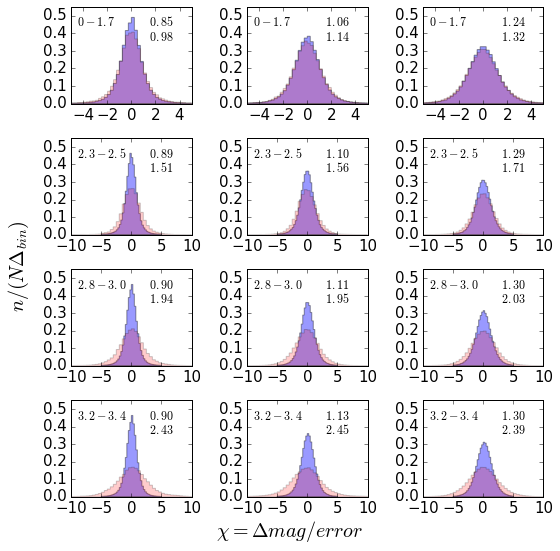

In [35]:
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

%matplotlib inline

fig, axs = plt.subplots(4,3, figsize=(8, 8))
fig.subplots_adjust(wspace=0.46, hspace=0.36, left=0.12, right=0.94, bottom=0.10, top=0.95)
store_fc_starB = np.zeros((3,4))

for i in range(len(tau_max_arr)):  # 
    for j in range(len(Min_arr) ):  # 
       
        # if not testing,  uncomment   datafileS,  vS,   datafileQ, vQ 
        datafileS = outDir+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'starsB'+'_mi_tau_ei-log_tau_'+\
                        str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
        vS = np.loadtxt(datafileS, unpack=True)
        chiS = vS[0]/vS[2]
        chiSok = chiS[np.abs(chiS)<5]
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        datafileQ = outDir+b+'_'+str(Min_arr[j])+'-'+str(Max_arr[j])+'_'+'qso'+'_mi_tau_ei-log_tau_'+\
                str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'.txt'
        vQ = np.loadtxt(datafileQ, unpack=True)
        chiQ = vQ[0]/vQ[2]
        chiQok = chiQ[np.abs(chiQ)<xlims_arr[i]]

        # plot histograms
        Xlabel = '$\chi = \Delta mag / error$'
        Ylabel = '$n / (N\Delta_{bin})$'
        Xmin = -xlims_arr[i]
        Xmax = xlims_arr[i]
        bins = 40 
        title= r'$ '+' '+ str(tau_min_arr[i])+'-'+str(tau_max_arr[i])+'$'
        plot2Chistograms(chiQok, chiSok, Xmin=Xmin, Xmax=Xmax, Ymin=0.0, 
                             Ymax=0.55, Xlabel=Xlabel, Ylabel=Ylabel, ax=axs[i,j],bins=bins,  
                         title=title)
        # save the value of robust width of stellar chi distribution...
        stdev_rob_S = 0.7414 *(np.percentile(chiSok,75) - np.percentile(chiSok,25) )
        #store_fc_starB[row,column] = [magnitude_max, deltaTrange]
        store_fc_starB[j,i] = stdev_rob_S
fig.text(0.5, 0.04, Xlabel, ha='center', va='center',fontsize=20)
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical',fontsize=20)

#name = 'poster_r_cut_qso_starsB_histogram_grid.png'
#name = None
name = outDir+'Fig_3_histogram_panels_corr.png'
if (name is None):
    plt.show() 
else:
    print 'saving plot to:', name
    plt.savefig(name, bbox_inches='tight')

In [43]:
# This are the data for Table 1 in the paper, with values of chi for various 
# magnitude-log(tau) bins for blue stars
store_fc_starB
np.savetxt(outDir+'SigmaG_chi_-StarsB.txt',store_fc_starB, header='0-1.7  2.3-2.5  2.8-3.0   3.2-3.4', 
           fmt='%2.4f    '*4)

In [140]:
store_fc_starB

array([[ 0.85123025,  0.89528021,  0.90391452,  0.90843273],
       [ 1.06679681,  1.10987207,  1.11973961,  1.13243149],
       [ 1.24832398,  1.29319014,  1.30201714,  1.30707115]])

In [46]:
store_fc_starB[0,:]

array([ 0.85123025,  0.89528021,  0.90391452,  0.90843273])

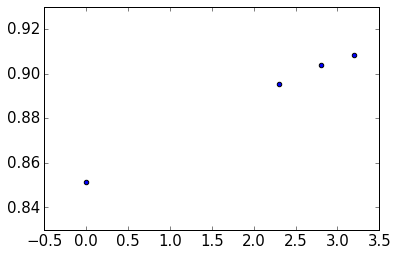

In [48]:
plt.scatter(tau_min_arr, store_fc_starB[0,:])

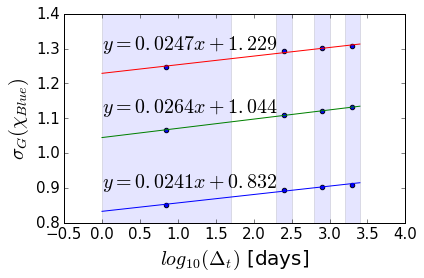

In [135]:
def func(x, a, b):
    return a * x + b

from scipy.optimize import curve_fit
# popt is func(x, popt*)

fig,ax = plt.subplots()

aCoeffArr = np.zeros(len(Min_arr))
bCoeffArr =np.zeros(len(Min_arr))
stdArr = np.zeros(len(Min_arr))
colors = ['']
for i in range(len(Min_arr)):
    tau_cen = (np.array(tau_max_arr) + np.array(tau_min_arr)) / 2.0
    popt, pcov = curve_fit(func, tau_cen, store_fc_starB[i,:])
    a,b = popt[0], popt[1]
    aCoeffArr[i] = a
    bCoeffArr[i] = b
    
    x = np.sort(np.append(np.array(tau_min_arr), tau_max_arr)) #np.linspace(tau_min_arr[0], tau_min_arr[-1])
    y = a * x + b
    std = np.std(a * np.array(tau_cen)  - store_fc_starB[i,:] )
    stdArr[i] = std
    ax.plot(x,y)
    ax.scatter(tau_cen, store_fc_starB[i,:])
    ax.text(x=0, y=store_fc_starB[i,0]+0.05,  s=r'$y='+str(a)[:6]+'x + '+str(b)[:5]+'$ ', fontsize=20)

for j in range(len(tau_min_arr)):
    ax.fill_between(x=[tau_min_arr[j],tau_max_arr[j]],y1=[0.8,0.8],y2=[1.4,1.4],alpha=0.1)

ax.set_ylim(0.8,1.4)
ax.set_xlabel(r'$log_{10} (\Delta _{t})$ [days]',fontsize=20)
ax.set_ylabel(r'$\sigma_{G}(\chi_{Blue})$',fontsize=20)
plt.tight_layout()
plt.savefig(outDir + 'Blue_Stars_coefficients.png')

In [137]:
# Store the linear correction coefficients 
data = np.column_stack((aCoeffArr, bCoeffArr, stdArr, Min_arr, Max_arr))
np.savetxt(outDir+'fc_starsB_a_b_coeff.txt',data, header='  a      b     stddev   rMagMin  rMagMax',fmt='%2.5f    %2.5f    %2.5f  %2.2f  %2.2f  ')


In [138]:
tau_cen

array([ 0.85,  2.4 ,  2.9 ,  3.3 ])

In [124]:
data

array([[  2.41828245e-02,   8.32582504e-01,   3.25637902e-03],
       [  2.64992486e-02,   1.04460552e+00,   1.22213012e-03],
       [  2.47674634e-02,   1.22913747e+00,   3.17345916e-03]])

In [102]:
x

array([ 0. ,  2.3,  2.8,  3.2,  1.7,  2.5,  3. ,  3.4])

In [103]:
y

array([ 1.22913747,  1.28610263,  1.29848637,  1.30839335,  1.27124216,
        1.29105613,  1.30343986,  1.31334684])

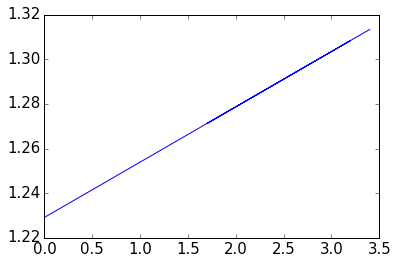

In [104]:
plt.plot(x,y)